## Rayna Hamilton
## 410.734: Practical Introduction to Metagenomics
## Final Project Proposal Supplement
## November 20, 2022

Below we will perform some prokaryotic genome fragment classification, using the dataset and approach illustrated by Perry and Beiko [1].  Support vector machines will be constructed to classify 500-bp fragments into species using length-256 tetranucleotide frequency vectors as input features.  As this is for demonstration purposes, we will only perform a small number of the total pairwise species comparisons (299 151) performed in the original article.

In [1]:
# import modules
import pandas as pd
import subprocess
import os
from sklearn.metrics import accuracy_score
import time
import random
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
genomes=pd.read_csv("table_S1.csv")#supplementary table containing all genomes
genomes.drop(0,inplace=True)
genomes.head() 

,Organism Name,NCBI Project ID,Domain,Phylum,Seq.,Genome Size (Mb),G+C Content
1,Acaryochloris marina MBIC11017,12997.0,Bacteria,Cyanobacteria,99,8.36,47.0
2,Acholeplasma laidlawii PG-8A,19259.0,Bacteria,Tenericutes,172,1.5,31.9
3,Acidiphilium cryptum JF-5,15753.0,Bacteria,Proteobacteria,5,3.97,67.1
4,Acidithiobacillus ferrooxidans ATCC 53993,16689.0,Bacteria,Proteobacteria,5,2.9,58.9
5,Acidobacteria bacterium Ellin345,15771.0,Bacteria,Acidobacteria,5,5.7,58.4


We will use the NCBI datasets command-line tool to download each genome specified in the supplementary table if it is not already present in our file system.

In [3]:
if not os.path.isdir("genomes"):
    os.mkdir("genomes")

for i,organism in enumerate(genomes["Organism Name"]):
    #print(organism)
    if i%100==0 and i!=0:
        print(f"{i} genomes downloaded")
    if not os.path.exists(f"genomes/{organism.replace(' ','_')}.fna"):#downloading genome should be a one-time cost
        subprocess.call(["datasets","download","genome","taxon",f"'{organism}'","--assembly-source","Genbank"], stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
        subprocess.call(["unzip","-o","ncbi_dataset.zip"], stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
        temp=os.listdir("/home/jupyter/ncbi_dataset/data/")
        genome_name=None
        #print(temp)
        for file in temp:
            if "GCA" in file:
                genome_name=file
                break
        #print(genome_name)
        if genome_name is not None:
            file_name=os.listdir(f"/home/jupyter/ncbi_dataset/data/{genome_name}")[0]
            subprocess.call(["mv",f"/home/jupyter/ncbi_dataset/data/{genome_name}/{file_name}",f"genomes/{organism.replace(' ','_').replace('/','someannoyingslash')}.fna"])#mv will get confused by slashes in name since it indicates a directory, so replace with something that isn't likely to otherwise be found in names
        else:
            print(f"Something went wrong downloading genome for {organism}.")#indicate any genomes that you will need to download manually
        subprocess.call(["rm","-rf","/home/jupyter/ncbi_dataset"])
print(f"{len([val for val in list(os.listdir('genomes')) if val.endswith('.fna')])} FASTA files were found in the genomes folder, of {len(genomes)} expected genomes.")

100 genomes downloaded
200 genomes downloaded
300 genomes downloaded
400 genomes downloaded
500 genomes downloaded
600 genomes downloaded
700 genomes downloaded
774 FASTA files were found in the genomes folder, of 774 expected genomes.


In [4]:
#identify any genomes which didn't download successfully
for organism in genomes["Organism Name"]:
    if not os.path.exists(f"genomes/{organism.replace(' ','_').replace('/','someannoyingslash')}.fna"):
        print(organism)

Let's make the list of tetranucleotides that we will be counting.

In [5]:
nucleotides=["A","T","G","C"]
tetranucleotides=[]
for a in nucleotides:
    for b in nucleotides:
        for c in nucleotides:
            for d in nucleotides:
                tetranucleotides.append(a+b+c+d)
print(f"There are {len(tetranucleotides)} to be counted, {len(set(tetranucleotides))} of which are unique.") #sanity check

There are 256 to be counted, 256 of which are unique.


It takes a long time to calculate frequencies and it is inefficient to store all in memory, so let's write each genome frequency dataset to a file.

In [6]:

if not os.path.isdir("frequencies"):
    os.mkdir("frequencies")

for i,organism in enumerate(genomes["Organism Name"]):
    if i%100==0 and i!=0:
        print(f"{i} organism frequencies calculated.")
    if not os.path.exists(f"frequencies/{organism.replace(' ','_').replace('/','someannoyingslash')}_freqs.csv"):

        file=f"genomes/{organism.replace(' ','_').replace('/','someannoyingslash')}.fna"
        if os.path.exists(file):
            sequence="".join([line.strip() for line in open(file).readlines() if not line.startswith(">")])#readlines() is often bad practice for large files, but since here we know that bacterial genomes are all fairly small, so we will use the list comprehension for speed

            frequencies=[]
            for start in range(0,len(sequence),500):
                if start+500<len(sequence):
                    region=sequence[start:start+500]
                    frequencies.append([])
                    for tetranucleotide in tetranucleotides:
                        frequencies[-1].append(region.count(tetranucleotide)/497)
            df=pd.DataFrame(frequencies)
            df.columns=tetranucleotides
            df.to_csv(f"frequencies/{organism.replace(' ','_').replace('/','someannoyingslash')}_freqs.csv",index=False)
        else:
            print(f"Could not find genome for {organism}.")
print(f"{len([val for val in list(os.listdir('frequencies')) if val.endswith('_freqs.csv')])} frequency files were found in the frequencies folder, of {len(genomes)} expected frequency files.")

100 organism frequencies calculated.
200 organism frequencies calculated.
300 organism frequencies calculated.
400 organism frequencies calculated.
500 organism frequencies calculated.
600 organism frequencies calculated.
700 organism frequencies calculated.
774 frequency files were found in the frequencies folder, of 774 expected frequency files.


In [7]:
pairs=[]
for i,organism_a in enumerate(genomes["Organism Name"]):
    for j,organism_b in enumerate(genomes["Organism Name"]):
        if i<j:
            pairs.append([organism_a,organism_b])
    
print(f"{len(pairs)} distinct genome pairs identified.")

299151 distinct genome pairs identified.


Above we have calculated all pairs of genomes from the 774 unique genomes.  Let's determine the taxonomic "distance" of each pair (i.e. the lowest level that they share) so that we can stratify our classification accuracies by taxonomic relationship.

In [8]:
genomes.index=genomes['Organism Name']
different_domain=[pair for pair in pairs if genomes.loc[pair[0],'Domain']!=genomes.loc[pair[1],'Domain']]
same_domain=[pair for pair in pairs if genomes.loc[pair[0],'Domain']==genomes.loc[pair[1],'Domain'] and genomes.loc[pair[0],'Phylum']!=genomes.loc[pair[1],'Phylum']]
same_phylum=[pair for pair in pairs if genomes.loc[pair[0],'Phylum']==genomes.loc[pair[1],'Phylum'] and pair[0].split(' ')[0]!=pair[1].split(' ')[0]]
same_genus=[pair for pair in pairs if pair[0].split(' ')[0]==pair[1].split(' ')[0] and genomes.loc[pair[0],'Phylum']==genomes.loc[pair[1],'Phylum'] and pair[0].split(' ')[1]!=pair[1].split(' ')[1]]
same_species=[pair for pair in pairs if pair[0].split(' ')[0]==pair[1].split(' ')[0] and genomes.loc[pair[0],'Phylum']==genomes.loc[pair[1],'Phylum'] and pair[0].split(' ')[1]==pair[1].split(' ')[1]]

In [9]:
print(f"The number of pairs for each group are: {len(different_domain)} in different domains, {len(same_domain)} in the same domain, {len(same_phylum)} in the same phylum, {len(same_genus)} in the same genus, {len(same_species)} in the same species.")

The number of pairs for each group are: 38213 in different domains, 173286 in the same domain, 84824 in the same phylum, 1996 in the same genus, 832 in the same species.


In [11]:
def make_training_data(file_a,file_b):
    df_a=pd.read_csv(file_a)
    df_a['organism']=[file_a]*len(df_a)
    df_b=pd.read_csv(file_b)
    df_b['organism']=[file_b]*len(df_b)
    data=pd.concat([df_a,df_b])
    data=data.sample(frac=1)
    return np.array(data[data.columns[:-1]]),np.array(data['organism'])

Let's try constructing some SVMs.  We will use a similar approach to Perry and Beiko, but we will only use 10 pairs for each level of taxonomic distance.

In [30]:
random.seed(10)

temp=None
results=[]
parameters = [
  {'C': [1000,10000], 'gamma': [0.01,0.001], 'kernel': ['rbf']},
 ]

for level in different_domain,same_domain,same_phylum,same_genus,same_species:
    chosen_pairs=random.sample(level,10)
    temp=time.time()
    print("Organism pairs analyzed are: ")
    for organism_a,organism_b in chosen_pairs:
        print(f'{", ".join(list(genomes.loc[organism_a,["Domain","Phylum","Organism Name"]]))} vs {", ".join(list(genomes.loc[organism_b,["Domain","Phylum","Organism Name"]]))}')
        X,y=make_training_data(f"frequencies/{organism_a.replace(' ','_').replace('/','someannoyingslash')}_freqs.csv",f"frequencies/{organism_b.replace(' ','_').replace('/','someannoyingslash')}_freqs.csv")
        svc = svm.SVC()
        clf = GridSearchCV(svc, parameters,n_jobs=-1)
        clf.fit(X,y)
        results.append([clf.cv_results_])
    
    print(f"Level complete, {time.time()-temp} seconds elapsed.")
    print(f"Average testing classification accuracy for this level was {sum([max(result[0]['mean_test_score']) for result in results[-10:]])/10}.\n")

Organism pairs analyzed are: 
Archaea, Crenarchaeota, Sulfolobus acidocaldarius DSM 639 vs Bacteria, Proteobacteria, Xanthomonas oryzae pv. oryzae MAFF 311018
Bacteria, Proteobacteria, Alteromonas macleodii Deep ecotype vs Archaea, Crenarchaeota, Metallosphaera sedula DSM 5348
Archaea, Euryarchaeota, Methanosaeta thermophila PT vs Bacteria, Thermotogae, Thermotoga sp. RQ2
Archaea, Euryarchaeota, Natronomonas pharaonis DSM 2160 vs Bacteria, Bacteroidetes, Parabacteroides distasonis ATCC 8503
Archaea, Euryarchaeota, Thermococcus onnurineus NA1 vs Bacteria, Proteobacteria, Wolbachia endosymbiont strain TRS of Brugia malayi
Bacteria, Proteobacteria, Aeromonas hydrophila subsp. hydrophila ATCC 7966 vs Archaea, Euryarchaeota, Methanococcus maripaludis C7
Bacteria, Proteobacteria, Coxiella burnetii CbuK_Q154 vs Archaea, Euryarchaeota, Methanococcus maripaludis C7
Bacteria, Verrucomicrobia, Methylacidiphilum infernorum V4 vs Archaea, Nanoarchaeota, Nanoarchaeum equitans Kin4-M
Archaea, Crenarc

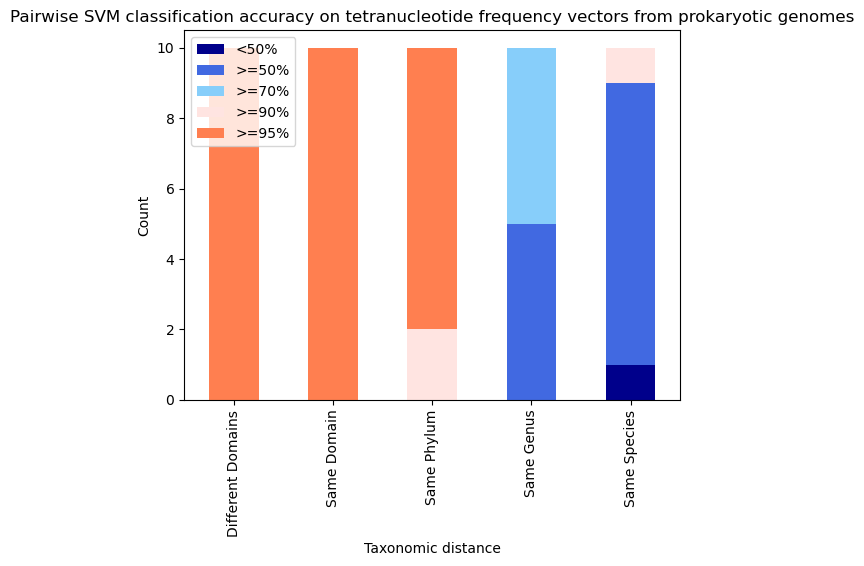

In [56]:
import matplotlib.pyplot as plt
#<50,50-70,70-90,90-95,95-99,99+
results_df=pd.DataFrame()#index by 5 groups
results_df['temp_indices']=[(0,10),(10,20),(20,30),(30,40),(40,50)]
results_df.index=["Different Domains","Same Domain","Same Phylum","Same Genus","Same Species"]
results_df["<50%"]=[sum([max(temp[0]['mean_test_score'])<0.5 for temp in results[i1:i2]]) for i1,i2 in results_df['temp_indices']]
results_df[">=50%"]=[sum([(max(temp[0]['mean_test_score'])<0.7 and max(temp[0]['mean_test_score'])>=0.5) for temp in results[i1:i2]]) for i1,i2 in results_df['temp_indices']]
results_df[">=70%"]=[sum([(max(temp[0]['mean_test_score'])>=0.7 and max(temp[0]['mean_test_score'])<0.9) for temp in results[i1:i2]]) for i1,i2 in results_df['temp_indices']]
results_df[">=90%"]=[sum([(max(temp[0]['mean_test_score'])>=0.9 and max(temp[0]['mean_test_score'])<0.95) for temp in results[i1:i2]]) for i1,i2 in results_df['temp_indices']]
results_df[">=95%"]=[sum([(max(temp[0]['mean_test_score'])>=0.95 and max(temp[0]['mean_test_score'])<0.99) for temp in results[i1:i2]]) for i1,i2 in results_df['temp_indices']]
results_df[">=95%"]=[sum([max(temp[0]['mean_test_score'])>=0.95 for temp in results[i1:i2]]) for i1,i2 in results_df['temp_indices']]
results_df.plot(kind='bar', stacked=True, color=["darkblue","royalblue","lightskyblue","mistyrose","coral","red"])
plt.xlabel('Taxonomic distance')
plt.ylabel('Count')
plt.title('Pairwise SVM classification accuracy on tetranucleotide frequency vectors from prokaryotic genomes')
plt.show()

Our results are unsurprising and much the same as the original publication: classification accuracy is very high when comparing very distantly-related species but decreases as relationships become closer.  Classification performance on same-species fragments into subspecies is really no better than random chance (assigning every fragment to species 1 would still give 50% accuracy if the genomes were equal length).  This result is likely due to use of relatively short tetranucleotide frequencies; perhaps use of longer k-mers for counting would yield higher accuracy for same-genus and same-species fragments. 

## References
1) Perry, S. C., & Beiko, R. G. (2010). Distinguishing microbial genome fragments based on their composition: evolutionary and comparative genomic perspectives. Genome biology and evolution, 2, 117–131. https://doi.org/10.1093/gbe/evq004